**IMPORTING REQUIRED MODULES**

In [1]:
# ignore warning
import warnings
warnings.filterwarnings('ignore')

import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer


# To handle emojis
import emoji

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score

**TRAINING DATA**

In [2]:
col_names = ['TWEET-ID', 'ENTITY', 'SENTIMENT', 'TWEET-CONTENT']
train_data = pd.read_csv('data/twitter_training.csv', names=col_names)
print(train_data.shape)
train_data.head()

(74682, 4)


,TWEET-ID,ENTITY,SENTIMENT,TWEET-CONTENT
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
train_data.describe()

,TWEET-ID
count,74682.000000
mean,6432.586165
std,3740.427870
min,1.000000
25%,3195.000000
50%,6422.000000
75%,9601.000000
max,13200.000000


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TWEET-ID       74682 non-null  int64 
 1   ENTITY         74682 non-null  object
 2   SENTIMENT      74682 non-null  object
 3   TWEET-CONTENT  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


**HANDLING NULL VALUES**

In [5]:
# Checking NAN values in dataframe
train_data.isnull().sum()

TWEET-ID           0
ENTITY             0
SENTIMENT          0
TWEET-CONTENT    686
dtype: int64

In [6]:
# Removing NAN values
train_data.dropna(inplace=True)
train_data.isnull().sum()

TWEET-ID         0
ENTITY           0
SENTIMENT        0
TWEET-CONTENT    0
dtype: int64

**HANDLING DUPLICATES VALUE**

In [7]:
# Checking duplicates values
print('Duplicate records : ', train_data.duplicated().sum())

Duplicate records :  2340


In [8]:
# Removing duplicates records
train_data.drop_duplicates(inplace=True)
print('Duplicate records : ', train_data.duplicated().sum())

Duplicate records :  0


**TEXT PREPROCESSING**

In [9]:
# Handling emojis
def handle_emoji(text):
    return emoji.replace_emoji(text, replace='')

# Handling punctuations
punctuations = string.punctuation
def remove_puctuation(text):
    return text.translate(str.maketrans('', '', punctuations)) # here punctuations must be string not list


# function for changing text to lowercase, removing stopwords, removing punctuations and stemming
ps = PorterStemmer()

def preprocessing(text):
    text = text.lower()
    tokens = word_tokenize(text)

    filtered_tokens = []
    # Combine punctuation removal with custom symbol removal
    for token in tokens:
        if token not in stopwords.words('english') and token not in ["'", ',', '`', '’']:
            filtered_tokens.append(ps.stem(token))

    return ' '.join(filtered_tokens)


# Functio to remove any digits
def pre(text):
    text = re.sub(r'\d', '', text).strip()  # Remove all digits using '\d'
    return text

In [10]:
train_data['TWEET-CONTENT'] = train_data['TWEET-CONTENT'].apply(handle_emoji)
train_data['TWEET-CONTENT'] = train_data['TWEET-CONTENT'].apply(remove_puctuation)
train_data['TWEET-CONTENT'] = train_data['TWEET-CONTENT'].apply(preprocessing)
train_data['TWEET-CONTENT'] = train_data['TWEET-CONTENT'].apply(pre)

In [11]:
train_data.head()

,TWEET-ID,ENTITY,SENTIMENT,TWEET-CONTENT
0,2401,Borderlands,Positive,im get borderland murder
1,2401,Borderlands,Positive,come border kill
2,2401,Borderlands,Positive,im get borderland kill
3,2401,Borderlands,Positive,im come borderland murder
4,2401,Borderlands,Positive,im get borderland murder


**DATA VISUALIZATION**

In [12]:
print('Unique values : ', train_data['SENTIMENT'].unique())
print('\nTotal number of record in each category : ')
print(train_data['SENTIMENT'].value_counts())

Unique values :  ['Positive' 'Neutral' 'Negative' 'Irrelevant']

Total number of record in each category : 
SENTIMENT
Negative      21698
Positive      19713
Neutral       17708
Irrelevant    12537
Name: count, dtype: int64


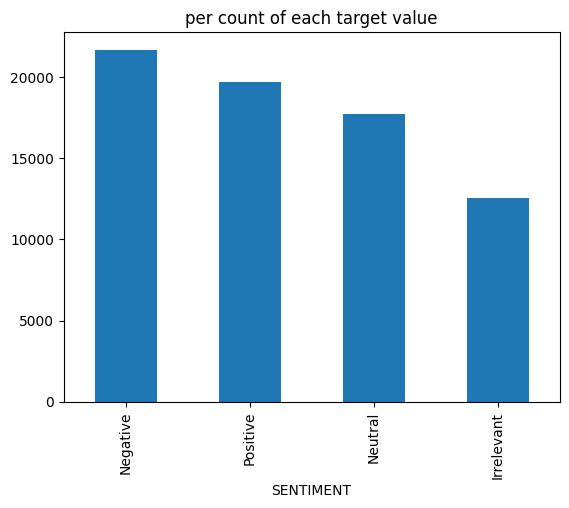

In [13]:
train_data['SENTIMENT'].value_counts().plot(kind = 'bar')
plt.title("per count of each target value")
plt.show()

In [14]:
# This function return a dictionary containing all words from respective sentiments(positive, negative, neutral and irrelevant sentiments).
def most_commom_words(df):
    sentiments = df['SENTIMENT'].unique()
    sentiment_analysis = {}

    for sentiment in sentiments:
        sentiment_analysis[sentiment] = []

        for txt in df[df['SENTIMENT']==sentiment]['TWEET-CONTENT'].tolist():
            for word in txt.split():
                sentiment_analysis[sentiment].append(word)
                
    return sentiment_analysis

# dictionary
sentiment_analysis = most_commom_words(train_data)
    

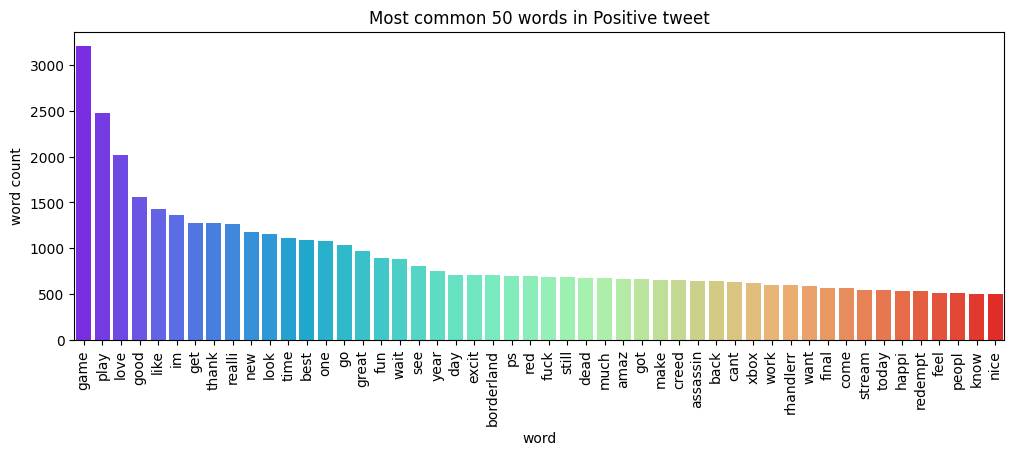

In [15]:
# plot most 50 common words from positive tweets
plt.figure(figsize=(12,4))
sns.barplot(x=pd.DataFrame(Counter(sentiment_analysis['Positive']).most_common(50))[0],y=pd.DataFrame(Counter(sentiment_analysis['Positive']).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in Positive tweet')
plt.xticks(rotation=90)
plt.show()

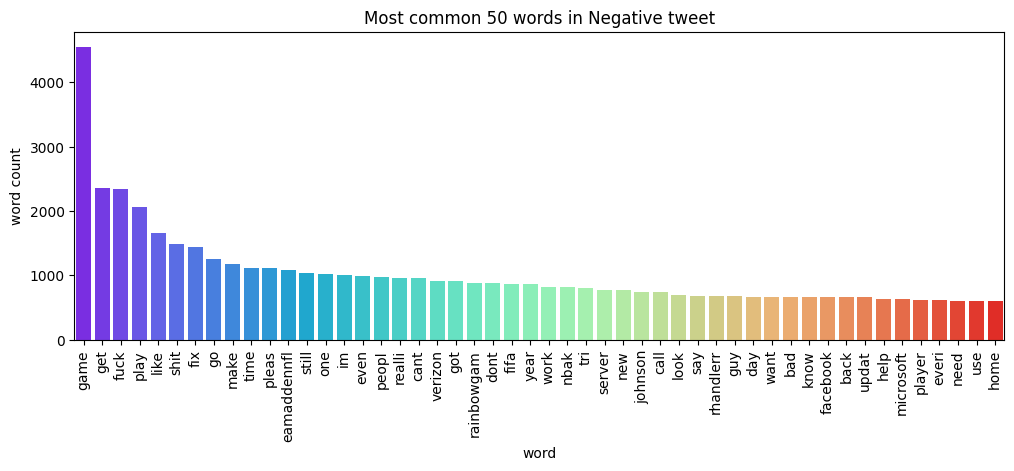

In [16]:
# plot most 50 common words from Negative tweets
plt.figure(figsize=(12,4))
sns.barplot(x=pd.DataFrame(Counter(sentiment_analysis['Negative']).most_common(50))[0],y=pd.DataFrame(Counter(sentiment_analysis['Negative']).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in Negative tweet')
plt.xticks(rotation=90)
plt.show()

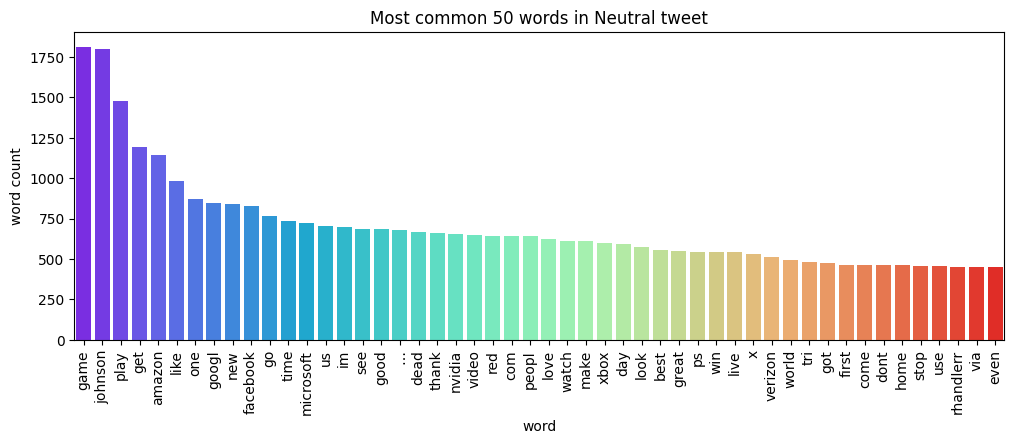

In [17]:

# plot most 50 common words from Neutral tweets
plt.figure(figsize=(12,4))
sns.barplot(x=pd.DataFrame(Counter(sentiment_analysis['Neutral']).most_common(50))[0],y=pd.DataFrame(Counter(sentiment_analysis['Neutral']).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in Neutral tweet')
plt.xticks(rotation=90)
plt.show()

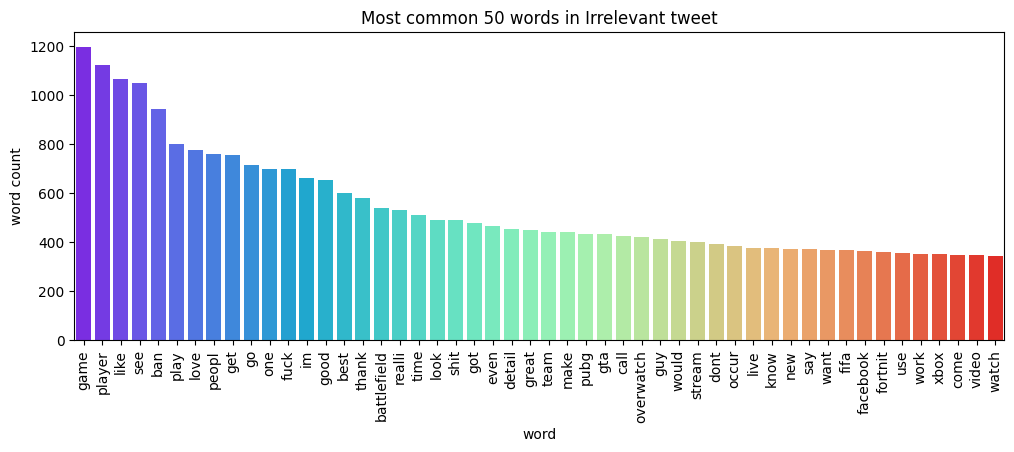

In [18]:
# plot most 50 common words from Irrelevant tweets
plt.figure(figsize=(12,4))
sns.barplot(x=pd.DataFrame(Counter(sentiment_analysis['Irrelevant']).most_common(50))[0],y=pd.DataFrame(Counter(sentiment_analysis['Irrelevant']).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in Irrelevant tweet')
plt.xticks(rotation=90)
plt.show()

**LABELING DATA**

In [21]:
# Negative - 0
# Positive - 1
# Neutral - 2
# Irrelevant - 3
train_data['SENTIMENT'] = train_data['SENTIMENT'].replace({'Positive':1,'Negative':0,'Neutral':2,'Irrelevant':3})
train_data.head()

,TWEET-ID,ENTITY,SENTIMENT,TWEET-CONTENT
0,2401,Borderlands,1,im get borderland murder
1,2401,Borderlands,1,come border kill
2,2401,Borderlands,1,im get borderland kill
3,2401,Borderlands,1,im come borderland murder
4,2401,Borderlands,1,im get borderland murder


**SPLITTING DATA**

In [22]:
x = train_data['TWEET-CONTENT']
y = train_data['SENTIMENT']

# splittind data
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(57324,) (57324,)
(14332,) (14332,)


**PIPELINE - 1**

In [23]:
# pipleine
sentiment_pipeline_rfc = Pipeline(
    steps=[
        ('tfidf',TfidfVectorizer(max_features=1000)),
        ('rfc',RandomForestClassifier(random_state=42))
    ]
)

# fit the data into pipeline
sentiment_pipeline_rfc.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [24]:
# predicting
y_pred = sentiment_pipeline_rfc.predict(x_test)

# evaluating model
print(accuracy_score(y_test,y_pred))

0.8506140106056377


**PIPELINE - 2**

In [25]:
# pipeline
sentiment_pipeline_clf = Pipeline([
    ('CountVectorizer',CountVectorizer(ngram_range=(2, 3))),
    ('clf',LogisticRegression(solver = 'liblinear', max_iter=400))
])

# fit the data into pipeline
sentiment_pipeline_clf.fit(x_train,y_train)

Pipeline(steps=[('CountVectorizer', CountVectorizer(ngram_range=(2, 3))),
                ('clf', LogisticRegression(max_iter=400, solver='liblinear'))])

In [26]:
# predicting
y_pred = sentiment_pipeline_clf.predict(x_test)

# evaluating model
print(accuracy_score(y_test,y_pred))

0.8898967345799609


**TESTING DATA**

In [27]:
col_names = ['TWEET-ID', 'ENTITY', 'SENTIMENT', 'TWEET-CONTENT']
test_data = pd.read_csv('data/twitter_validation.csv', names=col_names)
print(test_data.shape)
test_data.head()

(1000, 4)


,TWEET-ID,ENTITY,SENTIMENT,TWEET-CONTENT
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [28]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TWEET-ID       1000 non-null   int64 
 1   ENTITY         1000 non-null   object
 2   SENTIMENT      1000 non-null   object
 3   TWEET-CONTENT  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [29]:
# text preprocessing
test_data['TWEET-CONTENT'] = test_data['TWEET-CONTENT'].apply(handle_emoji)
test_data['TWEET-CONTENT'] = test_data['TWEET-CONTENT'].apply(remove_puctuation)
test_data['TWEET-CONTENT'] = test_data['TWEET-CONTENT'].apply(preprocessing)
test_data['TWEET-CONTENT'] = test_data['TWEET-CONTENT'].apply(pre)

In [30]:
# labeling test data
test_data['SENTIMENT'] = test_data['SENTIMENT'].replace({'Positive':1,'Negative':0,'Neutral':2,'Irrelevant':3})
test_data.head()

,TWEET-ID,ENTITY,SENTIMENT,TWEET-CONTENT
0,3364,Facebook,3,mention facebook struggl motiv go run day tran...
1,352,Amazon,2,bbc news amazon boss jeff bezo reject claim co...
2,8312,Microsoft,0,microsoft pay word function poorli samsungu ch...
3,4371,CS-GO,0,csgo matchmak full closet hack truli aw game
4,4433,Google,2,presid slap american face realli commit unlaw ...


In [33]:
x_test = test_data['TWEET-CONTENT']
x_test

0      mention facebook struggl motiv go run day tran...
1      bbc news amazon boss jeff bezo reject claim co...
2      microsoft pay word function poorli samsungu ch...
3           csgo matchmak full closet hack truli aw game
4      presid slap american face realli commit unlaw ...
                             ...                        
995    toronto art cultur capit canada wonder want st...
996    actual good move tot bring viewer one peopl go...
997    today suck time drink wine n play borderland s...
998            bought fraction microsoft today small win
999    johnson johnson stop sell talc babi powder us ...
Name: TWEET-CONTENT, Length: 1000, dtype: object

In [36]:
# predicting
y_pred = sentiment_pipeline_clf.predict(x_test)


# Negative - 0
# Positive - 1
# Neutral - 2
# Irrelevant - 3
y_pred

array([3, 2, 0, 0, 2, 0, 1, 1, 1, 0, 1, 1, 0, 2, 0, 1, 1, 0, 1, 0, 0, 2,
       3, 0, 2, 2, 0, 3, 3, 0, 1, 1, 0, 1, 0, 2, 2, 3, 1, 2, 1, 2, 2, 2,
       1, 2, 0, 0, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 0, 3, 0, 1, 1, 3, 0, 2,
       0, 3, 2, 0, 1, 0, 1, 1, 1, 3, 1, 3, 2, 2, 2, 1, 1, 2, 1, 2, 0, 3,
       0, 2, 2, 0, 1, 1, 3, 0, 0, 0, 2, 0, 2, 0, 1, 1, 2, 1, 2, 1, 0, 2,
       2, 1, 0, 2, 0, 2, 2, 1, 1, 2, 0, 0, 1, 0, 2, 0, 1, 2, 0, 2, 3, 1,
       2, 1, 1, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 1, 2, 1, 3, 1, 1, 2, 2,
       2, 3, 2, 0, 2, 1, 0, 2, 1, 3, 3, 3, 2, 1, 0, 0, 1, 1, 1, 2, 2, 1,
       3, 2, 2, 2, 1, 2, 0, 1, 2, 1, 1, 3, 3, 2, 1, 1, 2, 3, 2, 0, 0, 0,
       0, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 3, 2, 3, 0, 0, 3, 3, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 3, 3, 1, 1, 0, 1, 3, 2, 3, 3, 0, 2, 2, 1, 0, 3, 3,
       1, 1, 3, 3, 2, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 0, 2, 1, 2, 0, 1, 2,
       0, 1, 1, 3, 0, 2, 3, 1, 2, 3, 0, 2, 0, 1, 1, 0, 0, 0, 1, 0, 2, 1,
       2, 2, 0, 1, 0, 1, 0, 3, 2, 2, 1, 0, 2, 0, 3,